#  Dealiasing

Dealiases a radar volume for use in multidop

In [1]:
import pyart
from matplotlib import pyplot as plt
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import re
import time
import glob
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
from netCDF4 import Dataset


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
input_file = '/home/rjackson/data/radar/cfrad.20051224_143004.000_to_20051224_143751.000_Berrima_v6148_UNKNOWN_SUR.nc'
prev_file = '/home/rjackson/data/radar/cfrad.20051224_142004.000_to_20051224_142751.000_Berrima_v6147_UNKNOWN_SUR.nc'

data_path_berr = '/home/rjackson/data/radar/berr/uncorrected/'
out_path_berr = '/home/rjackson/data/radar/berr/'
radar_image_path = '/home/rjackson/plots/berr_deal/'
output_file = '/home/rjackson/data/radar/berr/BerrimaVol20060123_004003_deal.uf'

sounding_input_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20091124.111500.custom.cdf'
data_path_sounding = '/home/rjackson/data/soundings/'

# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 23
start_month = 1
start_hour = 13
start_minute = 00
start_second = 0

end_year = 2006
end_month = 1
end_day = 23
end_hour = 18
end_minute = 00
end_second = 0


/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:25.290666. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [3]:
radar = pyart.io.read(input_file)
radar.info()
radar_prev = pyart.io.read(prev_file)

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:25.965525. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (6480,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (6480,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (6480,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	gradient_wrt_angle:
		data: <ndarray of type: float32 and shape: (6480, 401)>
		long_name: Mean dopper velocity
		units: meters per second per gate (divided by Vn)
		standard_name: gradient_of_corrected_velocity_wrt_azimuth
		co

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:26.347308. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


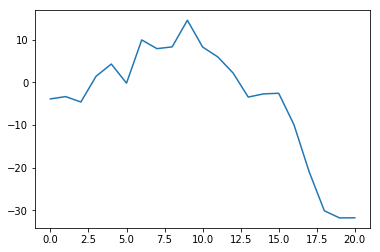

In [4]:
Sounding_netcdf = Dataset(sounding_input_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]
t = Sounding_netcdf.variables['tdry'][:]
v = v[u > -75]
alt = alt[u > -75]
u = u[u > -75]
steps = int(np.floor(len(u)/20))
wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt,u,v)

plt.plot(u[0::steps])
## 4DD expects speed, direction but HorizontalWindProfile outputs u_wind, v_wind
wind_profile.u = wind_profile.u_wind
wind_profile.v = wind_profile.v_wind
Sounding_netcdf.close()

azimuth = np.zeros(360)

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:26.883121. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


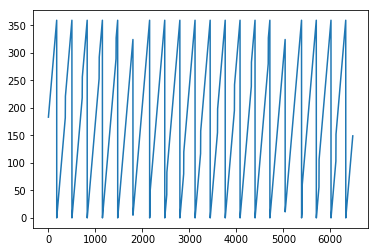

In [5]:
plt.plot(radar.azimuth['data'])

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:27.716592. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(-200, 200)

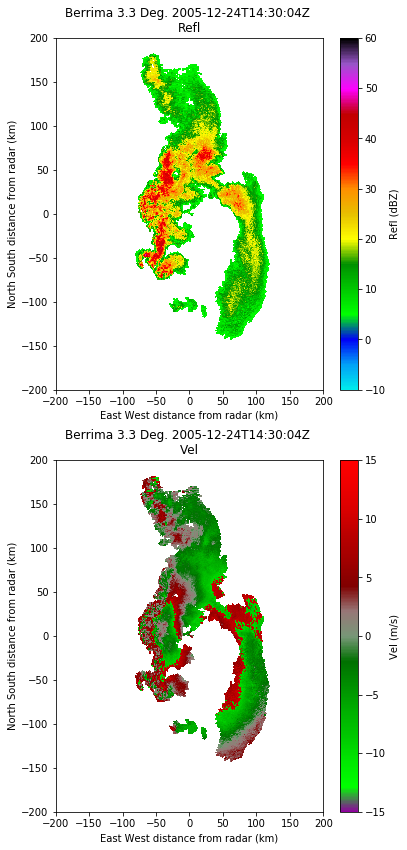

In [6]:
display = pyart.graph.RadarDisplay(radar)
ref_field = 'Refl'
vel_field = 'Vel'
rhohv_field = 'RHOHV'
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below(ref_field, 5)
gatefilter.exclude_masked(vel_field)
gatefilter.exclude_invalid(vel_field)
gatefilter.exclude_masked(vel_field)
gatefilter.exclude_invalid(vel_field)
gatefilter.exclude_above(ref_field, 80)
gatefilter.exclude_below(vel_field, -75)
gatefilter.exclude_above(vel_field, 75)
#gatefilter.exclude_below(rhohv_field, 0.6)
#gatefilter.exclude_masked('PHIDP')
gatefilter = pyart.correct.despeckle_field(radar,
                                           vel_field, 
                                           gatefilter=gatefilter,
                                           size=50)     
#gatefilter = pyart.correct.GateFilter(radar)
#gatefilter.exclude_below('Refl', 10)
#gatefilter.exclude_below('cross_correlation_ratio', 0.5)
plt.figure(figsize=(6,22))
plt.subplot(311)
display.plot_ppi(ref_field, sweep=2,
                 vmin=-10, vmax=60, cmap=pyart.graph.cm.NWSRef,
                 gatefilter=gatefilter)
plt.xlim([-200,200])
plt.ylim([-200,200])

plt.subplot(312)
display.plot_ppi(vel_field, sweep=2,
                 vmin=-15, vmax=15, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-200,200])
plt.ylim([-200,200])
#plt.subplot(313)
#display.plot_ppi(, sweep=1,
#                 vmin=0, vmax=180, cmap='jet',
#                 gatefilter=gatefilter)
#plt.xlim([-50,50])
#plt.ylim([-50,50])

In [7]:
#@jit(nopython=True, cache=True)
def get_fold_position(the_phidp): 
        tmp = the_phidp
        rth_pos = np.zeros((tmp.shape[0]), dtype=np.int32) 
          
        for j in range(tmp.shape[0]):
            max_phidp = -32768 
            for i in range(50, tmp.shape[1]):
                if the_phidp[j,i] < max_phidp-30.0 and the_phidp[j,i] > -1000.0:
                    rth_pos[j] = i                    
                    break
                if(the_phidp[j,i] > max_phidp):
                    max_phidp = the_phidp[j,i]
        return rth_pos
        return rth_pos

#@jit(nopython=True, cache=True)
def unfold_phidp(the_phidp, rth_position):
    tmp = the_phidp
    for j in range(len(rth_position)):
        i = rth_position[j]
        if i == 0:
            continue
        else:
            tmp[j, i:] += 180
    return tmp

def refold_vdop(vdop_art, v_nyq_vel, rth_position):
    tmp = vdop_art
    for j in range(len(rth_position)):
        i = rth_position[j]
        if i == 0:
            continue
        else:
            tmp[j, i:] += v_nyq_vel

    pos = (vdop_art > v_nyq_vel)
    tmp[pos] = tmp[pos] - 2*v_nyq_vel
    return tmp

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:29.042907. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [8]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below(ref_field, 5)
gatefilter.exclude_masked(ref_field)
gatefilter.exclude_invalid(ref_field)
gatefilter.exclude_masked(vel_field)
gatefilter.exclude_invalid(vel_field)
gatefilter.exclude_above(ref_field, 80)
gatefilter.exclude_below(vel_field, -75)
gatefilter.exclude_above(vel_field, 75)
#gatefilter.exclude_below('cross_correlation_ratio', 0.6)
#gatefilter.exclude_masked('phidp_bringi')

cp = deepcopy(radar.fields[ref_field]['data'])
radar.add_field_like(ref_field, 'reflectivity_horizontal', cp, replace_existing=True)
#gatefilter = pyart.correct.despeckle_field(radar,
#                                           'velocity', 
#                                           gatefilter=gatefilter,
#                                           size=50) 
#phidp_fold = radar.fields['phidp_bringi']['data']
#phidp_fold[gatefilter.gate_excluded] = -32768.0
#phidp_fold[phidp_fold < -1000.0] = np.nan
#rth = get_fold_position(phidp_fold)
             
vdop_art = deepcopy(radar.fields[vel_field]['data'])
v_nyq_vel = radar.instrument_parameters['nyquist_velocity']['data'][0]
#vdop_refolded = refold_vdop(vdop_art, v_nyq_vel, rth)
#radar.add_field_like('velocity', 'vdop_phidp_fold_corrected', 
#                     vdop_refolded, replace_existing=True)
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
corrected_velocity_4dd = pyart.correct.dealias_fourdd(radar,
                                                      last_radar=radar_prev,
                                                      vel_field=vel_field,
                                                      sonde_profile=wind_profile,
                                                      keep_original=False, 
                                                      gatefilter=gatefilter,
                                                      rsl_badval=-9999.0,
                                                      filt=1,
                                                      debug=False
                                                      )
radar.add_field_like(vel_field, 
                     'corrected_velocity', 
                     corrected_velocity_4dd['data'],
                     replace_existing=True)

radar.add_field('sim_velocity',
                pyart.util.simulated_vel_from_profile(radar, wind_profile),
                replace_existing=True)

difference = (radar.fields['corrected_velocity']['data']-radar.fields['corrected_velocity_region']['data'])/nyq
radar.add_field_like(vel_field, 
                     '4dd_minus_region_based', 
                     difference,
                     replace_existing=True)

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:30.064638. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


KeyError: 'corrected_velocity_region'

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:32.664472. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


KeyError: 'phidp_bringi'

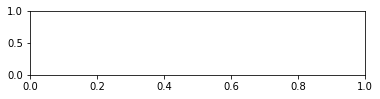

In [9]:
plt.subplot(311)
display.plot_ray('phidp_bringi', 368, gatefilter=gatefilter)
plt.subplot(312)
plt.plot(radar.range['data'][rth[360:370]]/1e3)
plt.subplot(313)
phidp = radar.fields['phidp_bringi']['data']
plt.plot(radar.fields['phidp_bringi']['data'][368])










## Plot the sounding

I use this as a way to verify that the final dealiased results make sense in terms of the wind directions. 


/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:03:36.632757. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 10000)

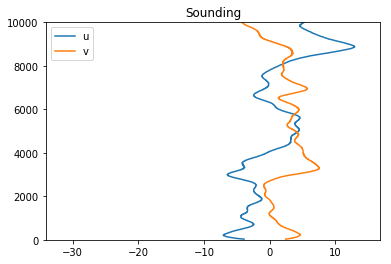

In [10]:
plt.plot(u,alt)
plt.plot(v,alt)
plt.legend(['u','v'])
plt.title('Sounding')
plt.ylim([0, 10000])

## Compare region based and 4DD

Compare region based and phase unwrapping. Region based algorithm sometimes unfolds velocities incorrectly by a nyquist interval. 

/home/rjackson/anaconda3/envs/freeman_prenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 12:04:46.354236. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


KeyError: 'corrected_velocity_region'

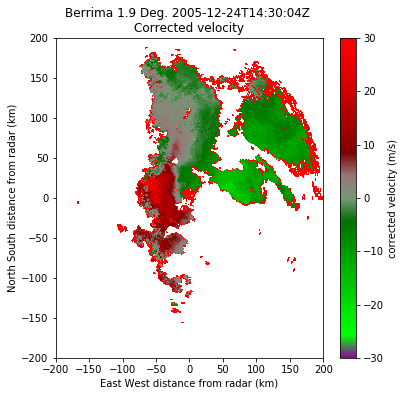

In [14]:
plt.figure(figsize=(6,20))

plt.subplot(311)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity', sweep=1,                 
                 vmin=-30, vmax=30, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-200,200])
plt.ylim([-200,200])

sim_vel = radar.fields['sim_velocity']['data'][:]
corr_vel = radar.fields['corrected_velocity_region']['data'][:]
radar.fields['corrected_velocity_region']['data'] = corr_vel


radar.fields['corrected_velocity_region']['data'] = corr_vel
sweep_slice = enumerate(radar.iter_slice())

#scorr += global_fold * nyquist_interval
plt.subplot(312)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=1,
                 vmin=-60, vmax=60, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([0,200])
plt.ylim([20,200])
plt.subplot(313)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity', sweep=1,
                 vmin=-40, vmax=40, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([0,200])
plt.ylim([20,200])

## Calculate gradient of dealiased image to remove badly folded time periods


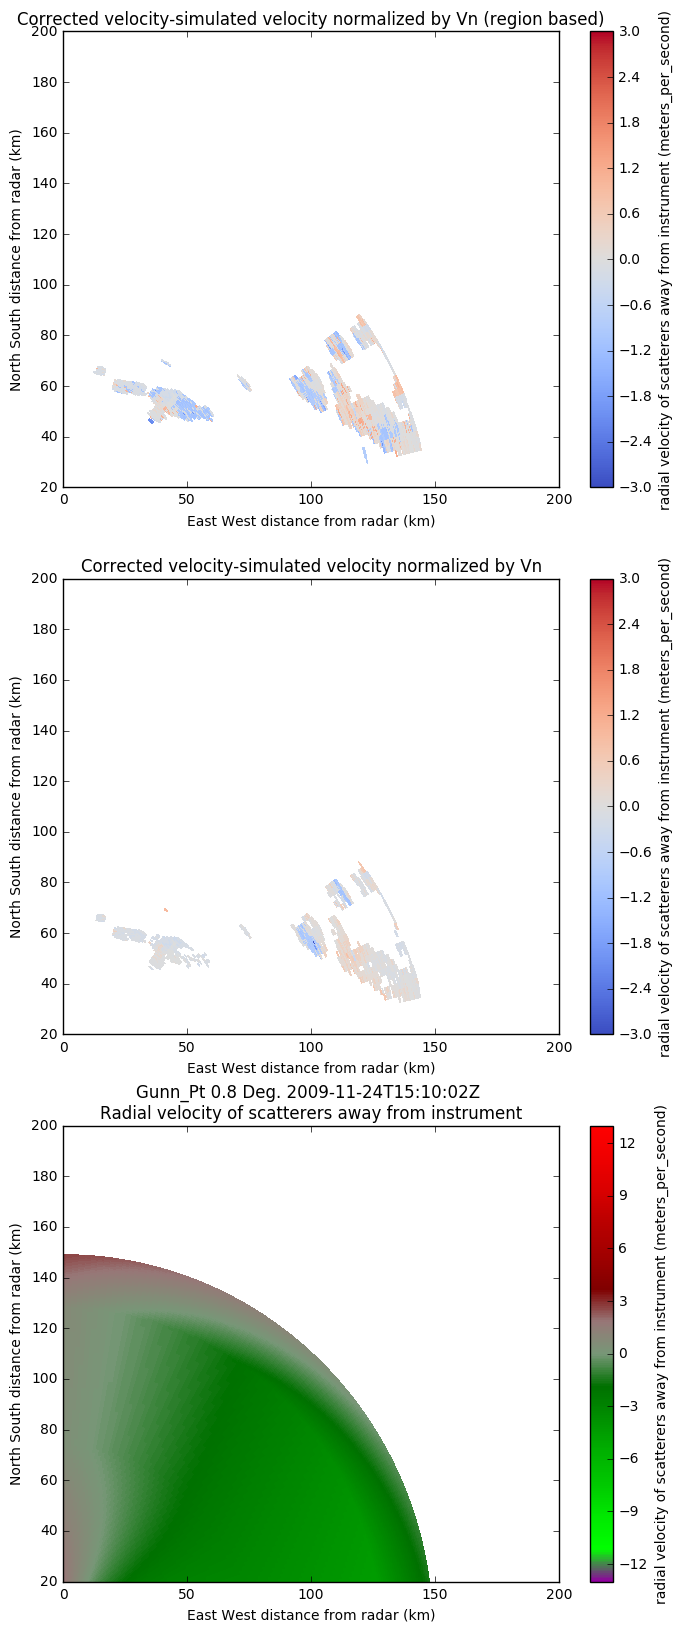

In [27]:
plt.figure(figsize=(8,20))
plt.subplot(311)

diff = radar.fields['corrected_velocity']['data']-radar.fields['sim_velocity']['data']
diff = diff/(radar.instrument_parameters['nyquist_velocity']['data'][1])
diff = np.ma.masked_where(diff > 90.0, diff)
radar.add_field_like('sim_velocity', 
                     'velocity_diff', 
                     diff, 
                     replace_existing=True)   

diff = radar.fields['corrected_velocity_region']['data']-radar.fields['sim_velocity']['data']
diff = diff/(radar.instrument_parameters['nyquist_velocity']['data'][1])  
diff = np.ma.masked_where(diff > 90.0, diff)
radar.add_field_like('sim_velocity', 
                     'velocity_diff_region', 
                     diff, 
                     replace_existing=True) 

display.plot_ppi('velocity_diff_region', sweep=1,
                vmin=-3, vmax=3, cmap='coolwarm')
plt.xlim([0,200])
plt.ylim([20,200])
plt.title('Corrected velocity-simulated velocity normalized by Vn (region based)')

plt.subplot(312)
display.plot_ppi('velocity_diff', sweep=1,
                vmin=-3, vmax=3, cmap='coolwarm')
plt.xlim([0,200])
plt.ylim([20,200])
plt.title('Corrected velocity-simulated velocity normalized by Vn')

plt.subplot(313)
display.plot_ppi('sim_velocity', sweep=1,
                vmin=-13, vmax=13,cmap=pyart.graph.cm.NWSVel)
plt.xlim([0,200])
plt.ylim([20,200])

intervals_start = np.arange(-5.5, 5.5, 1.0)
intervals_end = np.arange(-4.5, 6.5, 1.0)
intervals = np.zeros((len(intervals_start),2))
intervals[:,0] = intervals_start
intervals[:,1] = intervals_end

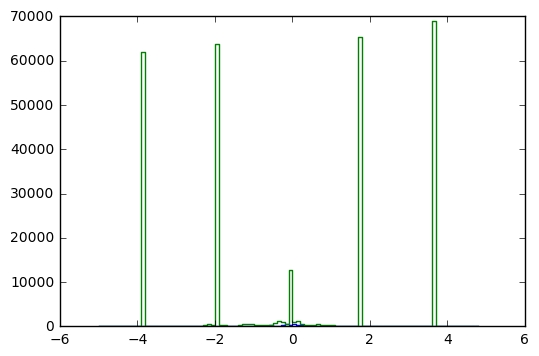

In [38]:
diff_region = radar.fields['velocity_diff_region']['data']
diff = radar.fields['velocity_diff']['data']
region_4dd = radar.fields['4dd_minus_region_based']['data']
hist_bins = np.arange(-5, 5, 0.1)
hist_4dd_diff, bins = np.histogram(diff[np.abs(region_4dd) > 0.05], hist_bins)
hist_diff, bins = np.histogram(diff_region[np.abs(region_4dd) > 0.05], hist_bins)
plt.step(bins[:-1], hist_4dd_diff)
#plt.step(bins[:-1], hist_diff)

## Display data with gatefilter

In [ ]:
gatefilter = pyart.correct.GateFilter(radar)

plt.figure(figsize=(6,14))
plt.subplot(211)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=0,
                 vmin=-30, vmax=30, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_above('velocity_diff', 2.5)
gatefilter.exclude_below('velocity_diff', -1.0)
gatefilter.exclude_above('gradient_wrt_angle', 0.3)
gatefilter.exclude_below('gradient_wrt_angle', -0.3)
gatefilter = pyart.correct.despeckle_field(radar, 
                                           'corrected_velocity',
                                           gatefilter=gatefilter,
                                           )
plt.subplot(212)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=1,
                 vmin=-30, vmax=30, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-150,150])
plt.ylim([-150,150])

## Batch process dealiasing with images

In [ ]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_berr(start_year, start_month, start_day,
                        start_hour, start_minute, end_year,
                        end_month, end_day, end_hour, 
                        end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
    
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_berr +
                      'BerrimaVol' +
                      year_str +
                      month_str +
                      day_str +
                      '_*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_berr +
                              'BerrimaVol' +
                              year_str +
                              month_str +
                              day_str +
                              '_*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-18:-3]
        
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
               
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.uf')
    print(file_name_str)    
    radar = pyart.io.read(file_name_str)
    return radar

def save_radar_deal_berr(time, radar):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.write_cfradial(file_name_str, radar)


def load_radar_deal_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.read(file_name_str, radar)
    return radar

# get_sounding_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time
  
    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a sounding object given a time period in the CPOL dataset
def get_sounding(time):
    from datetime import timedelta, datetime
    from netCDF4 import Dataset
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

First successfully dealiased frame = 01-21 01:10

In [ ]:
times_berr = get_radar_times_berr(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=1)

plt.figure(figsize=(6,6))
last_Radar = []

for times in times_berr:
    one_day_ago = times-timedelta(days=1, minutes=1)
    sounding_times = get_sounding_times(one_day_ago.year,
                                        one_day_ago.month,
                                        one_day_ago.day,
                                        one_day_ago.hour,
                                        one_day_ago.minute,
                                        times.year,
                                        times.month,
                                        times.day,
                                        times.hour,
                                        times.minute,
                                        minute_interval=60)
    sounding_time = sounding_times[len(sounding_times)-1]
    Sounding_netcdf = get_sounding(sounding_time)
    print(sounding_time)
    # Load sounding data
    Time = Sounding_netcdf.variables['time_offset'][:]
    base_time = Sounding_netcdf.variables['base_time'][:]
    alt = Sounding_netcdf.variables['alt'][:]
    u = Sounding_netcdf.variables['u_wind'][:]
    v = Sounding_netcdf.variables['v_wind'][:]
    t = Sounding_netcdf.variables['tdry'][:]
    spd = Sounding_netcdf.variables['wspd'][:]
    deg = Sounding_netcdf.variables['deg'][:]
    spd = spd[u > -75]
    deg = deg[u > -75]
    v = v[u > -75]
    alt = alt[u > -75]
    u = u[u > -75]
    
    
    steps = np.floor(len(u)/50)
    #steps=5
    wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt[0::steps],
                                                                 u[0::steps],
                                                                 v[0::steps])
    
    ## 4DD expects speed, direction but HorizontalWindProfile outputs u_wind, v_wind
    wind_profile.u = wind_profile.u_wind
    wind_profile.v = wind_profile.v_wind
    Sounding_netcdf.close()
    
    radar = get_radar_from_berr(times)
    
    ## 4DD requires the nyquist velocity be a field, 
    ## which is not in Berrima file
    nyq = 9.75
    nyquist_velocity = {'data': nyq*np.ones(radar.nrays,),
                        'meta_group': 'instrument_parameters',
                        'long_name': 'Nyquist velocity',
                        'units': 'm/s'}
    radar.instrument_parameters['nyquist_velocity'] = nyquist_velocity
    
    #data = ndimage.filters.generic_filter(radar.fields['Vel']['data'],
    #                                      pyart.util.interval_std, size = (6,6),
    #                                      extra_arguments = (-nyq, nyq))
    #filtered_data = ndimage.filters.median_filter(data, size = (3,3))
    #texture_field = pyart.config.get_metadata('Vel')
    #texture_field['data'] = filtered_data
    #radar.add_field('velocity_texture', texture_field, replace_existing = True)
    
    gatefilter = pyart.correct.despeckle.despeckle_field(radar,
                                                         'Vel')
    #gatefilter.exclude_above('velocity_texture', 2)

    # Do 4DD on scan if possible
    try:
        corrected_velocity_4dd = pyart.correct.dealias_fourdd(radar,
                                                              vel_field='Vel',
                                                              last_radar=last_Radar,
                                                              gatefilter=gatefilter,
                                                              sonde_profile=wind_profile,
                                                              keep_original=False,
                                                              )
    except:
        corrected_velocity_4dd = pyart.correct.dealias_region_based(radar,
                                                                    vel_field='Vel',
                                                                    gatefilter=gatefilter,
                                                                    sonde_profile=wind_profile,
                                                                    keep_original=False,
                                                                    centered=True)
    radar.add_field_like('Vel', 
                         'corrected_velocity', 
                          corrected_velocity_4dd['data'],
                          replace_existing=True)
    
    # Save new radar file
    save_radar_deal_berr(times, radar)
    
    # Output image to file
    plt.figure(figsize=(6,14))
    plt.subplot(211)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_Refl', sweep=0, gatefilter=gatefilter,
                     vmin=-10, vmax=70, cmap=pyart.graph.cm.NWSRef)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    
    plt.subplot(212)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_velocity', sweep=0, gatefilter=gatefilter,
                     vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    mean_vel = np.mean(radar.fields['corrected_velocity']['data'])
    plt.title('Corrected velocity mean = ' + str(mean_vel))
    plt.savefig((radar_image_path +
                 "%04d" % times.year +
                 "%02d" % times.month + 
                 "%02d" % times.day + 
                 "%02d" % times.hour +
                 "%02d" % times.minute + '.png'))
    plt.close()
    last_Radar = load_radar_deal_berr(times)